In [44]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.models import load_model
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


__________________________________________________________________________________________
# Dataset

Extracted from https://www.kaggle.com/datasets/nih-chest-xrays/data/data 
This dataset is a collection 112,120 chest X-ray images with 15 unique disease labels (including 'No Finding') from 30,805 unique patients. 
The images were sourced from the NIH system in the United Kingdom.
Labels were mined from radiological reports using natural language processing.



__________________________________________________________________________________________
# Problem Definition

### Background:
Chest X-ray (CXR) exam is one of the most frequent and cost-effective medical imaging examinations, especially for diagnosing issues related to the heart, lung, or thorax. 
Therefore, the sheer volume of CXRs generated is staggering. In the United States, an average of 236 CXRs per 1000 patients per year are performed, accounting for 25% of the annual total numbers of diagnostic imaging procedures
However, with an ageing population, the increase in the number CXRs is growing exponentially. However, growth of medical resources required to handle this increased strain is inadequate.
There is a severe lack of manpower already among doctors.\
To relieve doctors of their workload, AI can take over some of the simpler and more tedious tasks. 
One of those tasks is medical image screening.

### Objective:
From our dataset, we want to develop a program that can accurately identify and classify what disease(s) the CXR presents with. 
Note that one CXR can present with multiple conditions, and some conditions are more commonly found than others. 
This program aims to enhance diagnostic accuracy, reducing the time taken for interpretation, and supporting medical professionals in decision-making processes so as to reduce their already heavy workload.

________________________________________________________________________________
# Data Preperation & Cleaning



## 1. Load .csv into a dataframe with the image paths

In [2]:
# Load the metadata into a DataFrame
metadata_path = 'C:\\Users\\admin\\Desktop\\archive\\Data_Entry_2017.csv'
all_xray_df = pd.read_csv(metadata_path)

# Adjust the glob pattern to match the new subfolder structure and file naming pattern
image_folder_path = 'C:\\Users\\admin\\Desktop\\archive'
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(image_folder_path, 'images_0**', 'images', '*.png'))}

# Check if all files follow the expected naming pattern
expected_files = all_xray_df['Image Index'].tolist()
missing_files = [file for file in expected_files if file not in all_image_paths]
print(f"Number of files not found: {len(missing_files)}")

# Map Full Image Paths to the DataFrame
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# Print the number of missing image paths after mapping
nan_or_none_count = all_xray_df['path'].isna().sum()
print(f"Total count of rows without valid image paths: {nan_or_none_count}")

# Display the head of the DataFrame to verify the 'path' column
all_xray_df

Number of files not found: 0
Total count of rows without valid image paths: 0


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,C:\Users\admin\Desktop\archive\images_001\imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,C:\Users\admin\Desktop\archive\images_012\imag...


In [3]:
# an extra column, 'unnamed:11' appeared. Check out what values are inside
print(all_xray_df['Unnamed: 11'].unique())

[nan]


In [4]:
# 'unamed:11' column only contains '[nan]', therefore it does not contain any useful data and can be dropped. 
# Likely to be an issue with the original .csv file
all_xray_df = all_xray_df.drop('Unnamed: 11', axis=1)

## 2. Check the Datatypes


In [5]:
all_xray_df.dtypes
#all the datatypes look okay

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
path                            object
dtype: object

## 3. Check Each Column and Remove any Outliers



### 3.1: Follow-up #

In [6]:
print(all_xray_df['Follow-up #'].describe())
follow_up_counts = all_xray_df['Follow-up #'].value_counts().sort_index()
# who got 183 x rays??
# legit however, CXRs have a low dose of 0.1msv/ CXR. yearly natural exposure dose is 3msv of radiation

count    112120.000000
mean          8.573751
std          15.406320
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
Name: Follow-up #, dtype: float64


### 3.2: Patient Age

In [7]:
print(all_xray_df['Patient Age'].describe())


count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64


In [8]:
## find out number of people who have >100 in this column

age_over_100_count = all_xray_df[all_xray_df['Patient Age'] > 100].shape[0]
print(f"Number of people with age > 100: {age_over_100_count}")

Number of people with age > 100: 16


In [9]:
over_100 = all_xray_df[all_xray_df['Patient Age'] > 100]
over_100['Patient Age'].describe()

count     16.000000
mean     249.312500
std      130.435025
min      148.000000
25%      150.750000
50%      154.500000
75%      412.000000
max      414.000000
Name: Patient Age, dtype: float64

In [10]:
# oldest person in the world is 117, anything above that should be removed
# Remove ages above 100
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]
print(f"DataFrame shape after removal: {all_xray_df.shape}")

DataFrame shape after removal: (112104, 12)


### 3.2: Patient Age

In [11]:
print(all_xray_df['Patient Gender'].describe())

gender_counts = all_xray_df['Patient Gender'].value_counts()
m_count = gender_counts.get('M', 0)
f_count = gender_counts.get('F', 0)
other_count = gender_counts.sum() - (m_count + f_count)

print("")

print(f"Number of 'M': {m_count}")
print(f"Number of 'F': {f_count}")
print(f"Number of other categories: {other_count}")

#looks clean

count     112104
unique         2
top            M
freq       63328
Name: Patient Gender, dtype: object

Number of 'M': 63328
Number of 'F': 48776
Number of other categories: 0


### 3.4: View Position

In [12]:
View_counts = all_xray_df['View Position'].value_counts()
PA_count = View_counts.get('PA', 0)
AP_count = View_counts.get('AP', 0)
other_count = View_counts.sum() - (PA_count + AP_count)

print(f"Number of 'PA': {PA_count}")
print(f"Number of 'AP': {AP_count}")
print(f"Number of other categories: {other_count}")

#looks clean

Number of 'PA': 67299
Number of 'AP': 44805
Number of other categories: 0


### 3.5 Image Metadata

Note: 'OriginalImagePixelSpacing[x' and 'y]' will not be used in our neural network

In [13]:
print(all_xray_df['OriginalImage[Width'].describe())
print()
print(all_xray_df['Height]'].describe())
print()
print(all_xray_df['OriginalImagePixelSpacing[x'].describe())
print()
print(all_xray_df['y]'].describe())


count    112104.000000
mean       2646.035253
std         341.243771
min        1143.000000
25%        2500.000000
50%        2518.000000
75%        2992.000000
max        3827.000000
Name: OriginalImage[Width, dtype: float64

count    112104.000000
mean       2486.393153
std         401.270806
min         966.000000
25%        2048.000000
50%        2544.000000
75%        2991.000000
max        4715.000000
Name: Height], dtype: float64

count    112104.000000
mean          0.155651
std           0.016174
min           0.115000
25%           0.143000
50%           0.143000
75%           0.168000
max           0.198800
Name: OriginalImagePixelSpacing[x, dtype: float64

count    112104.000000
mean          0.155651
std           0.016174
min           0.115000
25%           0.143000
50%           0.143000
75%           0.168000
max           0.198800
Name: y], dtype: float64


## 4. Split the 'labelled' columns into binary columns
Make it easier for the CNN to understand the classifications

In [14]:
# List of disease labels
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 
                  'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 
                  'Pneumonia', 'Pneumothorax', 'No Finding']

# Creating binary columns for each disease label using .loc
for label in disease_labels:
    all_xray_df.loc[:, label] = all_xray_df['Finding Labels'].apply(lambda findings: 
                                                                    1 if label in findings.split('|') else 0)

all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,1
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,1,0,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1


# 5. Split into Train, Validate & Test (Accoding To Patient ID)

Our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits.

We cannot split randmomly as some images from the same patient may be found in different datasets. Aka Data Leakage, causes biased learning as CNN can recognise patient specific features, not the features of the conditions themselves. 

Therefore, we will split the images according to patient ID

In [15]:
# First, get a list of unique patient IDs and split this list into train + validation and test IDs
unique_patients = all_xray_df['Patient ID'].unique()
train_valid_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=2024)

# Now split the train + validation IDs into train IDs and validation IDs
train_ids, valid_ids = train_test_split(train_valid_ids, test_size=0.25, random_state=2024)  # 0.25 * 0.8 = 0.2

# Create the actual dataframes based on the split IDs
train_df = all_xray_df[all_xray_df['Patient ID'].isin(train_ids)]
valid_df = all_xray_df[all_xray_df['Patient ID'].isin(valid_ids)]
test_df = all_xray_df[all_xray_df['Patient ID'].isin(test_ids)]

print("Number of rows in train_df:", len(train_df))
print("Number of rows in valid_df:", len(valid_df))
print("Number of rows in test_df:", len(test_df))

# about 60/20/20 split

Number of rows in train_df: 67178
Number of rows in valid_df: 22120
Number of rows in test_df: 22806


In [16]:
# Check for data leakage by comparing unique patient identifiers.
def check_for_leakage(df1, df2, patient_col):
    df1_patients_unique = set(df1[patient_col].unique())
    df2_patients_unique = set(df2[patient_col].unique())
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    
    # If there's any overlap in patient identifiers, there's leakage
    leakage = len(patients_in_both_groups) > 0
    return leakage

# Check for leakage between each pair of sets
leakage_between_train_test = check_for_leakage(train_df, test_df, 'Patient ID')
print(f"Leakage between train and test sets: {leakage_between_train_test}")

leakage_between_train_valid = check_for_leakage(train_df, valid_df, 'Patient ID')
print(f"Leakage between train and validation sets: {leakage_between_train_valid}")

leakage_between_valid_test = check_for_leakage(valid_df, test_df, 'Patient ID')
print(f"Leakage between validation and test sets: {leakage_between_valid_test}")

Leakage between train and test sets: False
Leakage between train and validation sets: False
Leakage between validation and test sets: False


## 6. Preparing Images with tf.data

- to resize images to the same size
- memory efficiency: loads iamges in batches
- preprocess images the same way the images were preprocessed when training the models (e.g., normalizing pixel values). Consistent preprocessing is essential for the model to perform correctly.

In [17]:
# On the first batch, the the train_ds was augmented through flips, rotations, and brightness changes
# augmentation helps prevent overfiutting, artificially expanding the size and diversity of a training dataset by creating modified versions of images in the dataset
# For this iteration of the neural network, augmentation was turned off

def load_image_and_process(filepath, label, augment=False):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    #if augment:
       # image = tf.image.random_flip_left_right(image)
       # image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Convert the label data to categorical format
train_labels = train_df[disease_labels].values
valid_labels = valid_df[disease_labels].values
test_labels = test_df[disease_labels].values

# Create a tf.data.Dataset from the DataFrame
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['path'].values, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['path'].values, test_labels))

# Process the image and batch the datasets
batch_size = 32
train_ds = train_ds.map(load_image_and_process).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(load_image_and_process).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(load_image_and_process).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## 7. Visualize the Images, 1 from each category

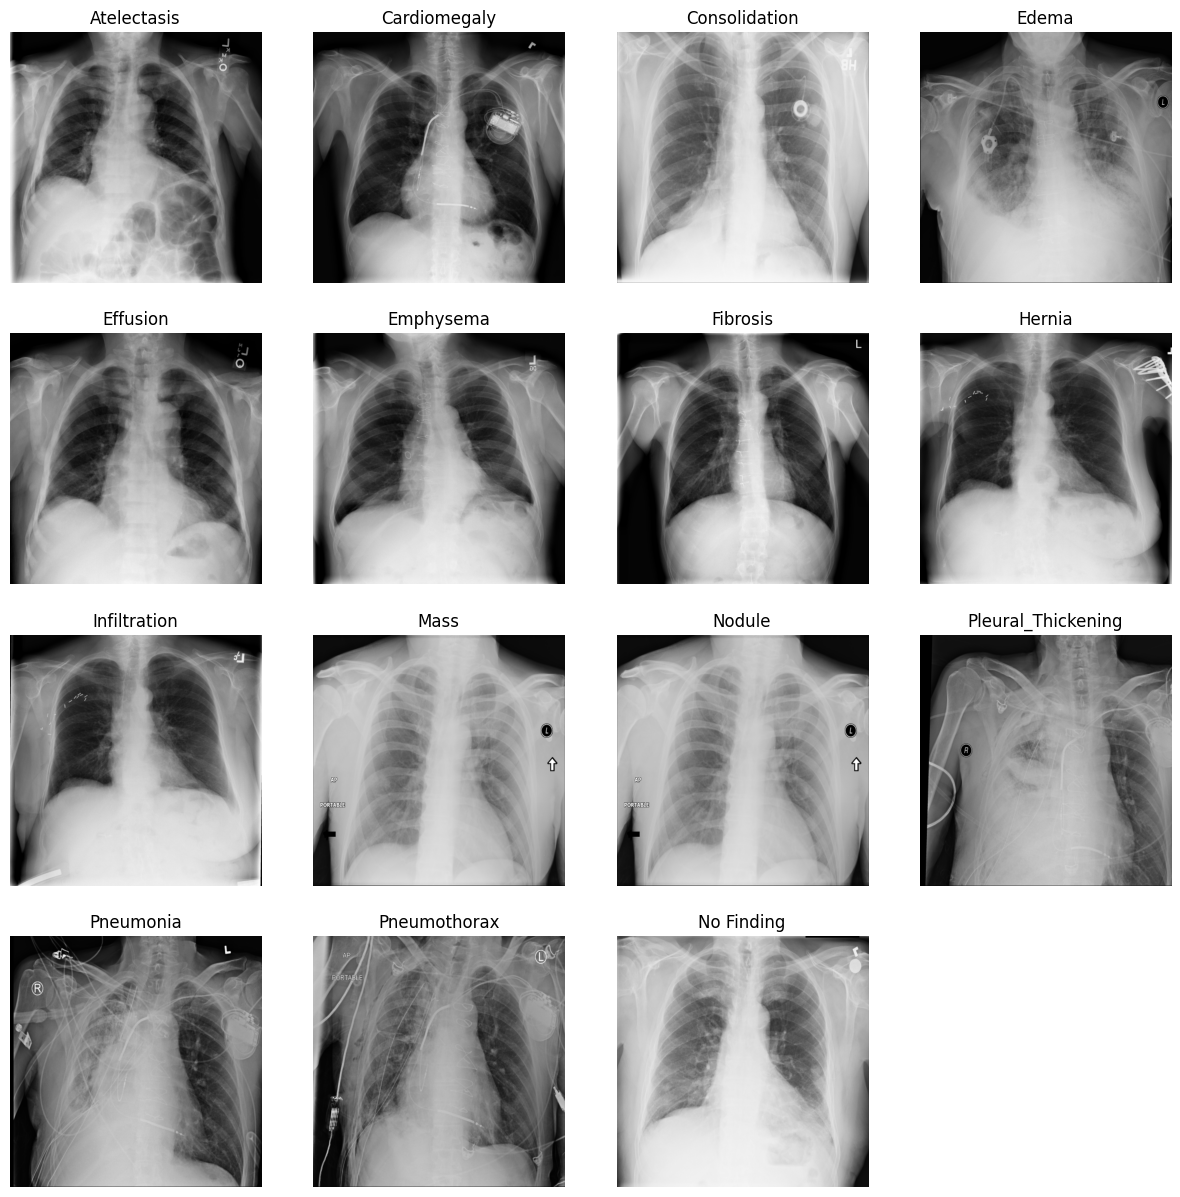

In [18]:
def format_labels(label_batch, disease_labels):
    """ Convert binary labels to string labels based on disease_labels """
    formatted_labels = []
    for labels in label_batch:
        label_names = [disease_labels[idx] for idx, label in enumerate(labels) if label == 1]
        if not label_names:  # If no disease is present
            label_names = ['No Finding']
        formatted_labels.append(', '.join(label_names))
    return formatted_labels

# Initialize dictionary to store one image and label per category
selected_images = {}
selected_labels = {}

# Iterate over the dataset to find the first instance of each category
for image_batch, label_batch in train_ds:
    # Convert labels to readable format
    formatted_labels = format_labels(label_batch.numpy(), disease_labels)
    
    # Check each label in the batch
    for img, labels in zip(image_batch.numpy(), formatted_labels):
        for label in labels.split(', '):  # Handle multiple labels per image
            if label not in selected_images:
                selected_images[label] = img
                selected_labels[label] = label
                if len(selected_images) == len(disease_labels):  # Stop if all categories are found
                    break
        if len(selected_images) == len(disease_labels):
            break
    if len(selected_images) == len(disease_labels):
        break

# Visualization function for the selected images
def show_selected_images(images, labels):
    plt.figure(figsize=(15,15))
    # Ensure the categories are displayed in order
    for idx, (label, img) in enumerate(sorted(images.items(), key=lambda x: disease_labels.index(x[0]))):
        ax = plt.subplot(4, 4, idx + 1)
        plt.imshow(img)
        plt.title(labels[label])
        plt.axis("off")
    plt.show()

show_selected_images(selected_images, selected_labels)


______________________________________________________________________________
# Exploratory data analysis/visualization

## 1. Number Of CXRs with A Specific Condition
Almost 50% of CXRs present with at least 1 condition.

We see that the distribution of diseases varies wildly. Hernia only has 227 cases! 

In [19]:
disease_counts = {}

# Populate the dictionary with disease counts
for disease in disease_labels:
    disease_counts[disease] = all_xray_df[disease].sum()

# Sort the dictionary by counts in descending order
sorted_disease_counts = dict(sorted(disease_counts.items(), key=lambda item: item[1], reverse=True))

# Print the sorted counts
for disease, count in sorted_disease_counts.items():
    print(f"Count of {disease}: {count}")

Count of No Finding: 60353
Count of Infiltration: 19891
Count of Effusion: 13316
Count of Atelectasis: 11558
Count of Nodule: 6331
Count of Mass: 5779
Count of Pneumothorax: 5301
Count of Consolidation: 4667
Count of Pleural_Thickening: 3384
Count of Cardiomegaly: 2776
Count of Emphysema: 2516
Count of Edema: 2302
Count of Fibrosis: 1686
Count of Pneumonia: 1430
Count of Hernia: 227


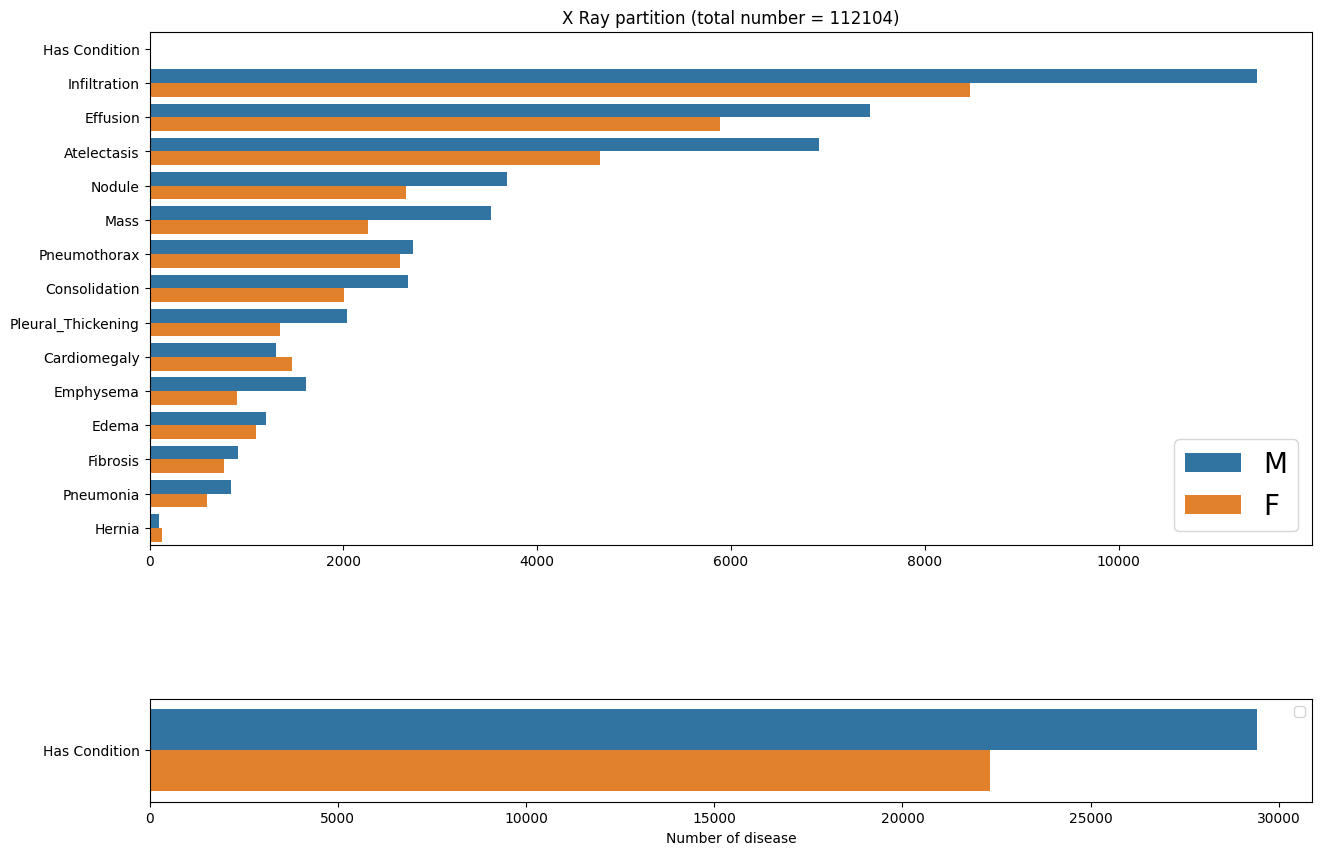

In [20]:
from matplotlib import gridspec  

diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
                'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
                'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Calculate the number of conditions per patient excluding 'No Finding'
all_xray_df['Conditions Count'] = all_xray_df[diseases].sum(axis=1)
# Create a binary column for patients with at least one condition
all_xray_df['Has Condition'] = all_xray_df['Conditions Count'] > 0

# Create a 'melted' DataFrame for plotting
melted_df = pd.melt(all_xray_df, id_vars=['Patient Gender'], value_vars=diseases + ['Has Condition'], var_name='Category', value_name='Count')
melted_df = melted_df[melted_df['Count'] > 0]

# Filter out 'Has Condition' for the first plot
disease_only_df = melted_df[melted_df['Category'] != 'Has Condition']

# Initialize the matplotlib figure and GridSpec
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1])

# The first subplot - for all diseases
ax1 = plt.subplot(gs[0])
sns.countplot(y='Category', hue='Patient Gender', data=disease_only_df, ax=ax1, order=melted_df['Category'].value_counts().index)
ax1.set(xlabel='', ylabel='', title='X Ray partition (total number = {})'.format(len(all_xray_df)))
ax1.legend(fontsize=20)

# The second subplot - for 'Has Condition' which indicates at least one condition present
ax2 = plt.subplot(gs[1])
condition_df = melted_df[melted_df['Category'] == 'Has Condition']
sns.countplot(y='Category', hue='Patient Gender', data=condition_df, ax=ax2)
ax2.set(xlabel='Number of disease', ylabel='')
ax2.legend('')

# Adjust layout spacing
plt.subplots_adjust(hspace=0.5)
plt.show()


## 2. Age Distribution of CXRs

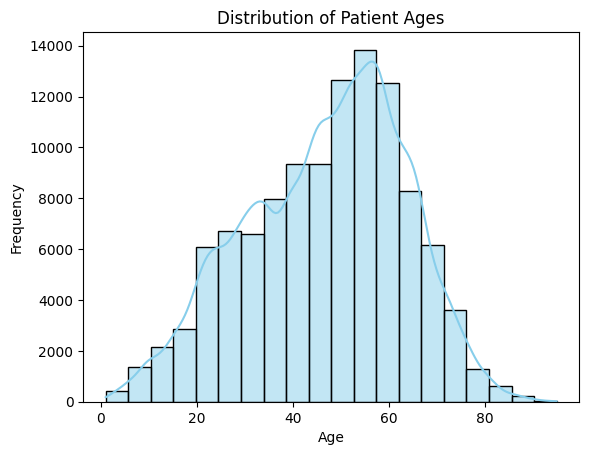

In [21]:
sns.histplot(all_xray_df['Patient Age'], bins=20, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribution of Patient Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

## 3. Correlation of Presence Of Condition and Age

Is there anything other than looking at the CXR that can predict the classification of CXR diseases?

The first correlation that comes to mind when we think about diseases is the correlation with age

In [22]:
# Copy the DataFrame to avoid altering the original data
df = all_xray_df.copy()

# Create a binary column where 1 indicates the presence of any disease except 'No Finding'
df['Has Disease'] = df['Finding Labels'].apply(lambda x: 0 if 'No Finding' in x else 1)

# Select only the columns we need for the correlation matrix
columns_to_consider = ['Patient Age', 'Has Disease']
correlation_df = df[columns_to_consider]

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

correlation_value = correlation_matrix.loc['Patient Age', 'Has Disease']
print("Correlation between 'Patient Age' and 'Has Disease':", correlation_value)

Correlation between 'Patient Age' and 'Has Disease': 0.07372198833972193


## 4. Correlation between Age and Sex for each Condition

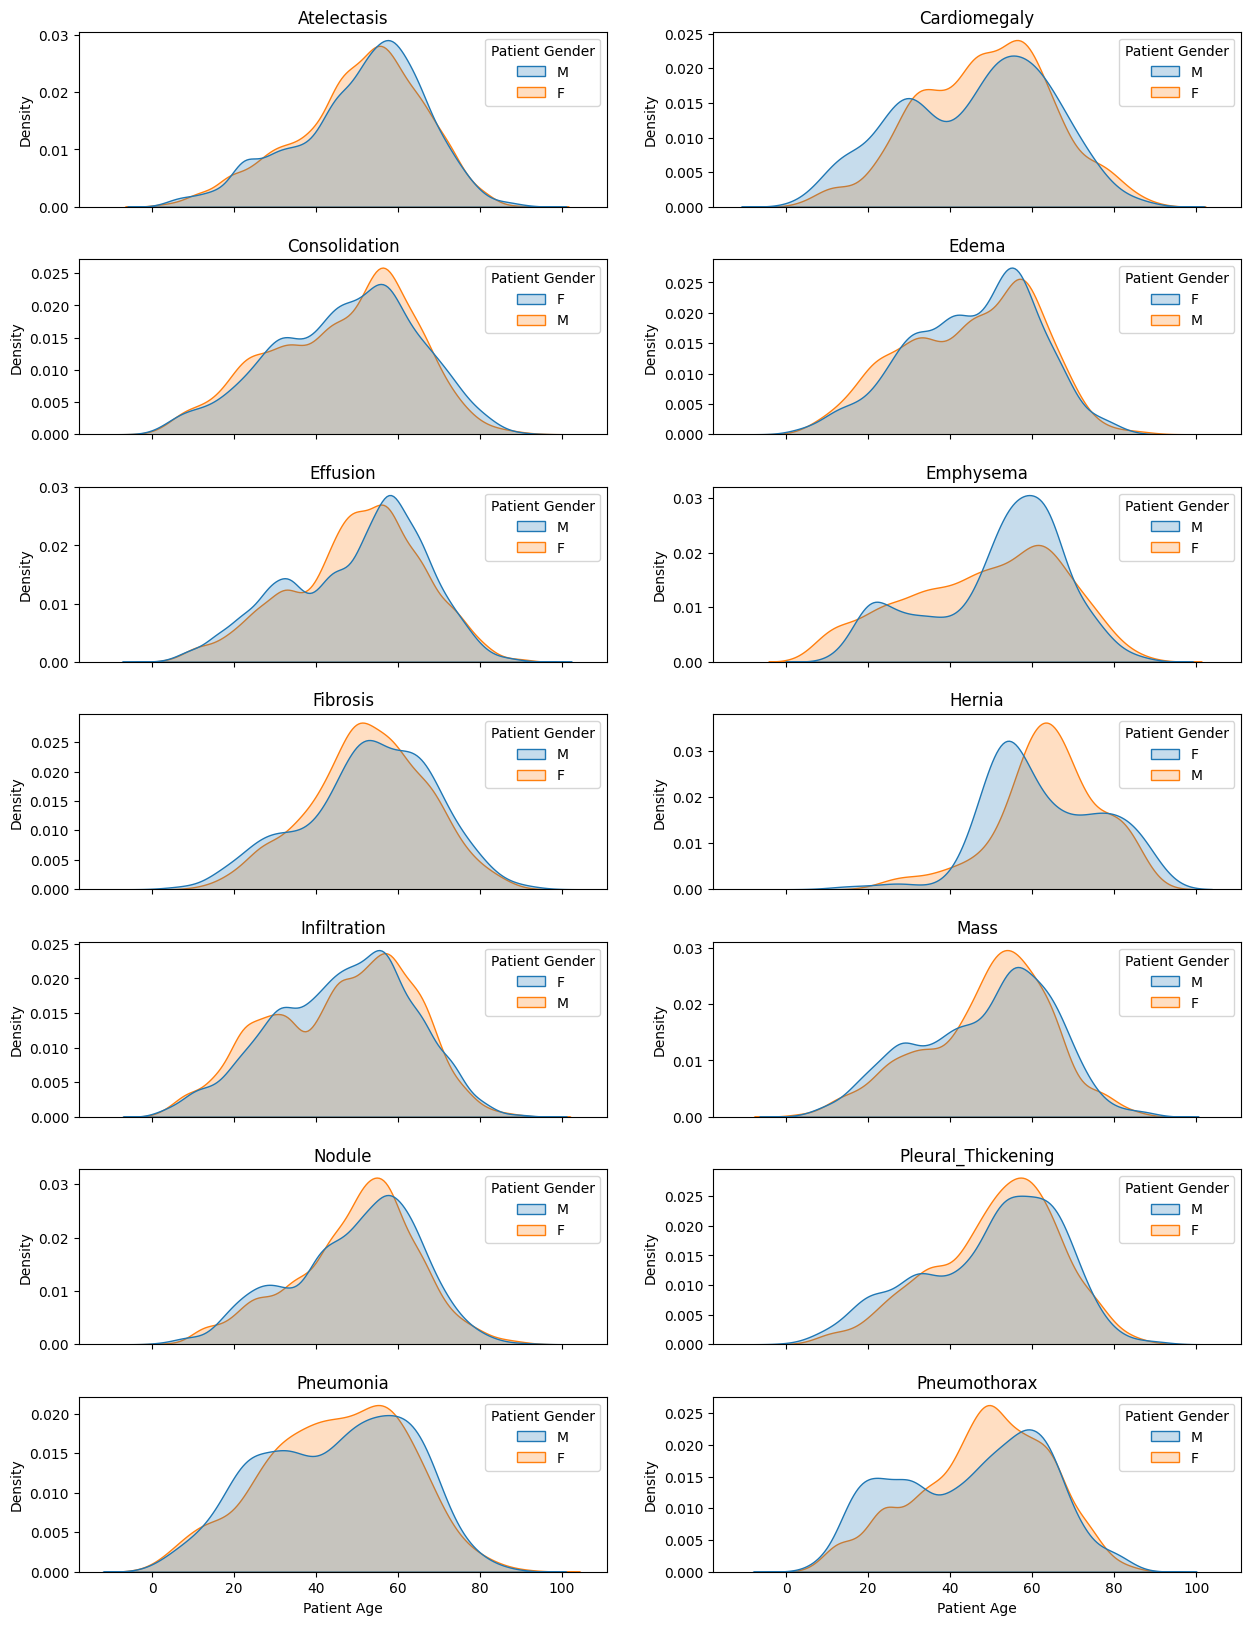

In [23]:
# Define the list of pathologies
pathology_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
                  'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
                  'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'] 

age_column = 'Patient Age' 

# Initialize the subplot structure
f, axarr = plt.subplots(len(pathology_list) // 2 + len(pathology_list) % 2, 2, sharex=True, figsize=(15, 20))
i, j = 0, 0

for pathology in pathology_list:
    # Filter the DataFrame for the current pathology excluding 'No Finding'
    pathology_df = all_xray_df[all_xray_df[pathology] == 1]
    
    # Plot the KDE for the current pathology
    sns.kdeplot(data=pathology_df, x=age_column, hue='Patient Gender', ax=axarr[i, j], common_norm=False, fill=True)
    axarr[i, j].set_title(pathology)

    # Update the indices for the next subplot
    j = (j + 1) % 2
    if j == 0:
        i += 1

# Remove any empty subplots
for k in range(i, len(axarr)):
    f.delaxes(axarr[k, j])
    j = (j + 1) % 2

# Adjust layout and display the plot
f.subplots_adjust(hspace=0.3)
plt.show()


In [24]:
disease_age_correlations = {}

# Calculate the correlation between each disease presence and patient age
for disease in pathology_list:
    correlation = all_xray_df['Patient Age'].corr(all_xray_df[disease])
    disease_age_correlations[disease] = correlation

for disease, corr_value in disease_age_correlations.items():
    print(f"Correlation between 'Patient Age' and presence of {disease}: {corr_value:.2f}")

Correlation between 'Patient Age' and presence of Atelectasis: 0.07
Correlation between 'Patient Age' and presence of Cardiomegaly: 0.00
Correlation between 'Patient Age' and presence of Consolidation: -0.00
Correlation between 'Patient Age' and presence of Edema: -0.01
Correlation between 'Patient Age' and presence of Effusion: 0.06
Correlation between 'Patient Age' and presence of Emphysema: 0.03
Correlation between 'Patient Age' and presence of Fibrosis: 0.04
Correlation between 'Patient Age' and presence of Hernia: 0.04
Correlation between 'Patient Age' and presence of Infiltration: -0.02
Correlation between 'Patient Age' and presence of Mass: 0.03
Correlation between 'Patient Age' and presence of Nodule: 0.04
Correlation between 'Patient Age' and presence of Pleural_Thickening: 0.04
Correlation between 'Patient Age' and presence of Pneumonia: -0.02
Correlation between 'Patient Age' and presence of Pneumothorax: -0.01


As presented in the graphs, and confirmed by the correlation values, there is little to no correlation between patient age and presence of a condition

## 5. Correlation between Diseases

In [33]:
# Count the number of rows with multiple labels
all_xray_df['label_count'] = all_xray_df['Finding Labels'].apply(lambda x: len(x.split('|')))
multiple_labels_count = (all_xray_df['label_count'] > 1).sum()

print(f"Number of rows with multiple labels: {multiple_labels_count}")

Number of rows with multiple labels: 20792


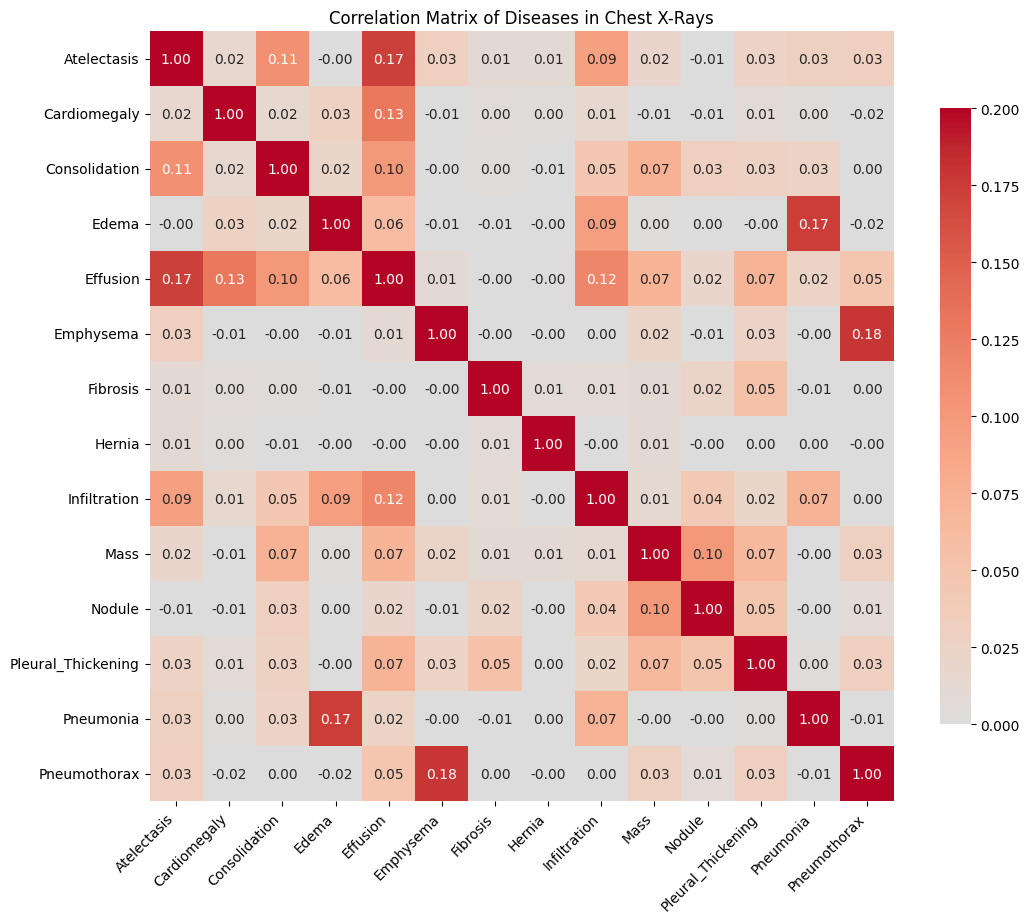

In [36]:
# Calculating the correlation matrix
correlation_matrix = all_xray_df[diseases].corr()

# Setting up the matplotlib figure
plt.figure(figsize=(12, 10))

# Drawing the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'shrink': .8}, vmin=0, vmax=0.2, center=0)

# Adding titles and labels
plt.title('Correlation Matrix of Diseases in Chest X-Rays')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()


There is no correlation between diseases, except for a few combinations.

In [41]:
from itertools import combinations

# Generating all possible combinations of two diseases
disease_pairs = list(combinations(diseases, 2))

# Counting how many times each pair occurs together
pair_counts = {}
for pair in disease_pairs:
    # Correcting the approach to use .loc for better performance and to avoid the warning
    condition = (all_xray_df[pair[0]] == 1) & (all_xray_df[pair[1]] == 1)
    count = all_xray_df.loc[condition].shape[0]
    pair_counts[pair] = count

# Convert the dictionary to a DataFrame for better visualization
pair_counts_df = pd.DataFrame(list(pair_counts.items()), columns=['Disease Pair', 'Count'])

# Sorting the DataFrame by count in descending order to see the most common pairs
pair_counts_df.sort_values(by='Count', ascending=False, inplace=True)

# Displaying the top 10 most common disease pairs
print(pair_counts_df.head(10))


                     Disease Pair  Count
49       (Effusion, Infiltration)   4000
3         (Atelectasis, Effusion)   3275
7     (Atelectasis, Infiltration)   3264
77         (Infiltration, Nodule)   1546
26      (Consolidation, Effusion)   1287
50               (Effusion, Mass)   1254
1    (Atelectasis, Consolidation)   1223
30  (Consolidation, Infiltration)   1221
76           (Infiltration, Mass)   1157
15       (Cardiomegaly, Effusion)   1063


________________________________________________________________________________________________________________________
# Machine Learning Techniques

# 1. Simple CNN Model Using Keras & Tensor Flow

For our first run, we will use something simple. 3 Convolutional layers, with 32, 64, and 64 filters respectively before the Dense layer

- Input Layer:  Explicitly specifies the input shape of the data, ensuring that the model knows what kind of input it is receiving.
- Convolutional Layer: Applies 32/64 filters with a kernel size of 3x3, using ReLU (Rectified Linear Unit) activation.
- MaxPooling Layer: Reduces the spatial dimensions (height and width) of the output from the previous convolutional layer using a 2x2 pooling window.
- Flatten Layer: Converts the 3D output of the previous layers into a 1D array to be fed into the dense layers
- Dense Layer: A fully connected layer with 64 neurons, using ReLU activation
- Dropout Layer: Randomly sets input units to 0 with a frequency of 0.5 at each step during training, helping to prevent overfitting
- Output Layer: A dense layer with num_classes neurons, one for each class, using softmax activation for multi-class classification

Adam Optimizer (Adaptive Moment Estimation)
- provides Adaptive Learning Rate, calculates individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients
- efficient: my CPU is dying
- Has learning rate of 0.001

### 1.1 Build A Simple CNN Model

In [45]:
# Define the CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  # Explicit Input layer specifying the input shape,  ensuring that the model knows what kind of input it is receiving
        # First convolutional layer with 32 filters, a kernel size of 3x3, and ReLU activation
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Second convolutional layer with 64 filters and a kernel size of 3x3, followed by a MaxPooling layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Third convolutional layer with 64 filters and a kernel size of 3x3
        Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten the output of the convolutions to feed into the dense layer
        Flatten(),
        
        # Dense layer with 64 neurons
        Dense(64, activation='relu'),
        Dropout(0.5),  # Dropout for regularization
        
        # Output layer with 'num_classes' neurons, one for each class, using softmax activation for classification
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model with a suitable optimizer, loss function, and metric for classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# images are 512x512 pixels with 3 color channels (RGB)
input_shape = (512, 512, 3)
num_classes = 15

# Build the model
model = build_model(input_shape, num_classes)

# Print the model summary to see the structure and parameters
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 984064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      62,980,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,037,455 (240.47 MB)

 Trainable params: 63,037,455 (240.47 MB)

 Non-trainable params: 0 (0.00 B)

### 1.2 Train The Simple CNN Model
Note: this section is not enabled

![alternatvie text](https://github.com/quammenn/Test/assets/145742237/cfe1a1dd-17cd-4e14-9a98-78a0d7fb4a82)


### 1.3 Model Accuracy For Simple CNN Model:
Training Accuracy: 0.5554

Validation Accuracy: 0.5423

Validation Loss: 0.2099

Test Accuracy was not calculated

# 2. Deeper CNN Model Using Keras & Tensor Flow

### Changes Made:
- Images in the train dataset were not augmented
- Deeper Neural Network with 4 convolutional layers, instead of 3
- Twice as many filters per layer
- Batch Normalization after each convolutional layer
- Implementation of a learning rate Scheduler

### Explanation Of Changes:
Augmentation of Images:
- Artifically increasing the dataset variance feels unecessary, when the images are already so similar.

Deeper neural network:
- learn increasingly complex and abstract features at each layer. In our CXRs, initial layers might learn simple features like edges and textures, intermediate layers could identify which parts of the CXR are associated with the disease, and deeper layers might recognize the disease itself.
- Improve accuracy
- Negative impacts: CPU resource intensive, more prone to overfitting. Mitigate with dropout.

Twice as many Filters per layer:
- Increase feature detection, capture more and wider variety. More complex model
- Overfitting prone
  
Batch Normalization:
- improve speed and perforamnce. CPU dead alr
- Improves learning rate and makes it more stable. Normalizes the input layer by adjusting and scaling activations.

Implementation of a learning rate Scheduler:
- Improved convergence of to cost function minimum. Avoids local minima and saddle points
- Enhances generalization of Model to real world data. Especially important here in the CXR classification context


### 2.2 Build A Deeper CNN Model

Note: Deeper CNN has fewer parameters each neuron in the convolutional layer is only connected to a small region of the input (determined by the kernel size), and weights are shared across the entire input.
Flatten also reduces the number of connections to the dense layer


In [46]:
# Define a learning rate scheduler
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 50:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        #BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    # Make sure all lines within the function are indented at the same level
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming the input images are 512x512 pixels with 3 color channels (RGB)
input_shape = (512, 512, 3)
# Assuming we have 15 classes
num_classes = 15

# Build the model
model = build_model(input_shape, num_classes)

# Print the model summary to see the structure and parameters
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 512, 512, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512, 512, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,021,519 (64.93 MB)

 Trainable params: 17,020,815 (64.93 MB)

 Non-trainable params: 704 (2.75 KB)

### 2.2 Train the Deeper CNN Model
Note: this section is not enabled

![alternatvie text](https://github.com/quammenn/Test/assets/145742237/b350fe5c-26cd-4f18-9a72-61b8cce3d169)


### 2.3 Model Accuracy For Deeper CNN Model:


Training Accuracy: 0.5543

Validation Accuracy: 0.5357

Validation Loss: 0.2079

# 3. Using a Pre-trained model, Resnet

Our image classificiations as accurate as we would like. So we will try a pre-trained model.
ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.

### 3.0 Generate 224 x 224 Images Required For ResNet

### 3.1 Build/Import Resnet Model


In [47]:
NUM_CLASSES = 15

# Load the ResNet50 model, pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Create a prediction layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,701,263 (98.04 MB)

 Trainable params: 2,113,551 (8.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 3.2 Train Resnet Model


### 3.3 Model Accuracy For Resnet:


# 4. Introducing Class Weights & Changing Activation Model
Consistent 50% classification accuracy and increasing training and validation showsoverfitting and instability in the training process, pointing to an issue with the dataset. Possible causes:
1. Overfitting
2. Class imbalnce

Issue with class imbalance: traditional methods of calculating class weights might not be directly applicable since they assume a single label per instance.


In the softmax model, the trainable parameters are from two layers only: 1024 units each connecting to 224x224x3 input features, and 15 units each connecting to 1024 features.

In the sigmoid model, if the base layers are trainable, then all parameters from ResNet50 (over 23 million) plus the parameters from the added dense layers contribute to the count.

One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets.

Looking at the number of CXRs per class, The number of infiltration classes is 2 orders of magnitude higher than the smallest class, hernia.

This presents several issues. 
1. The CNN may become biased towards the majority class(es) in the dataset, as it tends to learn features that are more representative of the dominant classes. This bias can result in poor performance on minority classes, leading to misclassification or even complete neglect of minority class instances.
2. Imbalanced datasets may not provide sufficient training examples for minority classes, which can hinder the CNN's ability to generalize well to unseen data. The model may fail to capture the underlying patterns or variations present in minority class instances, resulting in reduced performance on real-world data.
3. we used the standard loss function, cross-entropy, that treats all classes equally. In imbalanced datasets, this can lead to difficulties in optimizing the loss function, as errors on minority classes contribute less to the overall loss compared to errors on majority classes. As a result, the model may prioritize optimizing performance on the majority classes at the expense of minority classes.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss.

Solution:

Multiply each example from each class by a class-specific weight factor, so that the overall contribution of each class is the same.
This encourages the model to focus more on correctly classifying instances from the minority classes. 
1. Compute class weights based on the class frequencies in the training data. The weight is inversly proportional to class frequency
2. Modify the loss function used for training the CNN

By applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function

Accounting for class imbalance is especially important in the realm of medical imaging, as the number of conditions that a CXR can present with are vast.
Besides the 14 conditions that were provided, other conditions include rib fractures, boot shaped heart, pneumomediastinum, mediastinal - all of which have lower frequencies than even Hernia. 

A doctor's value lies in being able to look at any CXR an diagonse it accurately, from the hundreds of conditions that a CXR can present.

To bring our CXR to the next level, we need to account for class imbalance.


In [48]:
# Define the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(disease_labels), activation='sigmoid')(x)  # Use sigmoid for multi-label classification
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use binary_crossentropy for multi-label classification
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,701,263 (98.04 MB)

 Trainable params: 2,113,551 (8.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 5. Focusing Model On Single-Label CXRs Only

Considering that we have tried our own models and pre-trained models to similar results, we should take a look at our dataset. A potential issue is the prevelance of multi-class labels. 
Multi-class labels introduce complexity by requiring the model to differentiate and classify instances into multiple categories simultaneously. This complexity can overwhelm the model's capacity to discern nuanced patterns and make accurate predictions. As a result, our model might struggle to achieve the level of performance required for reliable predictions in such scenarios.

Before we move further into accurately doing multi-class labelling, let us first try to solve binary classificiation. 

### Note: This code was imported from another jupyter notebook, and will not work if ran in this section of this notebook. The results of the cells are inserted as markdown cells below each raw cell

### 5.1 Check Multi-labels


Number of rows with multiple labels: 20796


### 5.2 Remove rows with multiple labels


Number of rows with a single label: 91324
Dataframe with 91324 rows × 27 columns

### 5.3 Split into Train, Validate & Test (Accoding To Patient ID)


Number of rows in train_df: 54511

Number of rows in valid_df: 18487

Number of rows in test_df: 18326

### 5.4 Check For Leakage

Leakage between train and test sets: False

Leakage between train and validation sets: False

Leakage between validation and test sets: False

### 5.5 Prepare images with tf.data

### 5.6 Build Simple CNN Model with a learning rate scheduler

In [49]:
from tensorflow.keras.models import Sequential

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 50:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# Define the CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  # Explicit Input layer specifying the input shape,  ensuring that the model knows what kind of input it is receiving
        # First convolutional layer with 32 filters, a kernel size of 3x3, and ReLU activation
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Second convolutional layer with 64 filters and a kernel size of 3x3, followed by a MaxPooling layer
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Third convolutional layer with 64 filters and a kernel size of 3x3
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Flatten the output of the convolutions to feed into the dense layer
        Flatten(),
        
        # Dense layer with 64 neurons
        Dense(64, activation='relu'),
        Dropout(0.5),  # Dropout for regularization
        
        # Output layer with 'num_classes' neurons, one for each class, using softmax activation for classification
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model with a suitable optimizer, loss function, and metric for classification
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# images are 512x512 pixels with 3 color channels (RGB)
input_shape = (512, 512, 3)
num_classes = 15

# Build the model
model = build_model(input_shape, num_classes)

# Print the model summary to see the structure and parameters
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 510, 510, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 510, 510, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 253, 253, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 253, 253, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 124, 124, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 124, 124, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │      15,745,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,803,023 (60.28 MB)

 Trainable params: 15,802,703 (60.28 MB)

 Non-trainable params: 320 (1.25 KB)

### 5.7 Compile & Train the Simple CNN Model


| Model            | Epoch number | Training Accuracy | Training Loss | Val_accuracy | Val_loss |
|------------------|--------------|-------------------|---------------|--------------|----------|
| Simple Single Label | 1            | 0.6479            | 3.6291        | 0.6337       | 2.7413   |
| Simple Single Label | 2            | 0.6725            | 1.5887        | 0.6550       | 1.6070   |
| Simple Single Label | 3            | 0.6733            | 1.4053        | 0.6555       | 1.4584   |
| Simple Single Label | 4            | 0.6733            | 1.3745        | 0.6555       | 1.4051   |
| Simple Single Label | 5            | 0.6733            | 1.3715        | 0.6555       | 1.5024   |



Test Loss: 0.111356

Test Accuracy: 64.92%



| Atelectasis | Cardiomegaly | Consolidation | Edema | Effusion | Emphysema | Fibrosis | Infiltration | Mass | Nodule | Pleural_Thickening | Pneumonia | Pneumothorax | No Finding | Hernia |
|-------------|--------------|---------------|-------|----------|-----------|----------|--------------|------|--------|--------------------|-----------|--------------|------------|--------|
| 66.23%      | 67.17%       | 64.87%        | 66.45%| 67.51%   | 65.92%    | 66.73%   | 65.38%       | 67.12%| 64.99% | 65.77%             | 66.60%    | 67.33%       | 65.94%      | 67.02% |

________________________________________________________________________________________________________________________
# Insights - What We Learned

First, we need to understand the terms in the models

In machine learning, training and validation loss are two important metrics that are used to evaluate the performance of a model.

1. Training Accuracy
- The proportion of correct predicitons made by the model on the train set

2. Training Loss: 
- Error or cost calculated on the training dataset, measuring how well the model fits the training data.
- However, a very low training loss can also indicate overfitting, where the model is too closely fitted to the training data, including the noise or fluctuations that do not generalize well to new data.
- Trends in Training loss and their meaning
    - Decreasing Training Loss: model is learning, becoming more accurate
    - Increasing training loss: excessively high learning rate, might cause the model's weights to diverge rather than converge to a minimum.
    - Fluctuating Training Loss: possible causes include high variance in batch data, too high learning rate. Suggests that the model is struggling to find a stable path toward convergence.
    - Plateauing Training Loss: model has reached its capacity, no further learning. Could mean model is underfitting, needs more complex models/features

3. Validation Accuracy
- The proportion of correct predicitons made by the model on the train set

5. Validation Loss:
- Error calculated on validation set.
- It measures how well the model is able to generalize to new, unseen data. A validation set acts as a proxy for the test set, providing an unbiased evaluation of a model fit during the training phase.
- Trends in Validation loss and their meaning
    - Decreasing validation loss is desirable, means that model is learning and improving its ability to generalize to new data
    - Increasing validation loss: model might be starting to overfit the training data. Model is performing worse on the validation set over time, possibly due to memorizing the training data rather than learning to generalize.
    - Fluctuating Validation Loss: learning rate might be too high
    - Plateauing Validation Loss: model may have reached its learning capacity given the current architecture and hyperparameters. Need changes in model or data setup


## 1. Summaries Of Model Performance

In [25]:
metadata_path = 'C:\\Users\\admin\\Desktop\\archive\\Results.csv'
results_df = pd.read_csv(metadata_path)
results_df

,Model,Epoch number,Training accuracy,Training loss,Val_accuracy,Val_loss
0,Simple CNN,1,0.4938,0.2718,0.54270,0.2718
1,Simple CNN,2,0.5578,0.2213,0.54270,0.2213
2,Simple CNN,3,0.5575,0.2163,0.54270,0.2163
3,Simple CNN,4,0.5574,0.2123,0.54270,0.2123
4,Simple CNN,5,0.5578,0.2138,0.54270,0.2138
5,Deeper CNN,1,0.4228,0.3585,0.53240,0.2251
6,Deeper CNN,2,0.5539,0.2116,0.46960,0.2972
7,Deeper CNN,3,0.5543,0.2094,0.53570,0.2079
8,Resnet,1,0.3586,205.3530,0.54270,827.4474
9,Resnet,2,0.3435,1055.4363,0.34070,1752.7198


Classification Accuracy Of Models on Test Set

| Model                        | Atelectasis | Cardiomegaly | Consolidation | Edema | Effusion | Emphysema | Fibrosis | Infiltration | Mass | Nodule | Pleural_Thickening | Pneumonia | Pneumothorax | No Finding | Hernia | Test Accuracy | Test Loss |
|------------------------------|-------------|--------------|---------------|-------|----------|-----------|----------|--------------|------|--------|--------------------|-----------|--------------|------------|--------|---------------|-----------|
| Deeper CNN Model             | 52.70%      | 49.50%       | 50.00%        | 52.30%| 50.60%   | 50.90%    | 49.30%   | 48.80%       | 49.10%| 49.60% | 48.00%             | 49.60%    | 48.40%       | 50.00%     | 47.50% | -             | -         |
| Resnet1                      | 49.85%      | 50.87%       | 49.94%        | 49.53%| 50.90%   | 48.91%    | 49.72%   | 49.33%       | 49.73%| 51.01% | 49.39%             | 49.83%    | 49.72%       | 49.79%     | 50.27% | 53.46%        | 783.43    |
| Resnet2                      | 49.85%      | 50.87%       | 49.94%        | 49.53%| 50.90%   | 48.91%    | 49.72%   | 49.33%       | 49.73%| 51.01% | 49.39%             | 49.83%    | 49.72%       | 49.79%     | 50.27% | 57.66%        | 0.2279388 |
| Simple Model with Single label| 66.23%      | 67.17%       | 64.87%        | 66.45%| 67.51%   | 65.92%    | 66.73%   | 65.38%       | 67.12%| 64.99% | 65.77%             | 66.60%    | 67.33%       | 65.94%     | 67.02% | 64.92%        | 0.111356  |
| Average                      | 54.66%      | 54.60%       | 53.69%        | 54.45%| 54.98%   | 53.66%    | 53.87%   | 53.21%       | 53.92%| 54.15% | 53.14%             | 53.96%    | 53.79%       | 53.88%     | 53.77% | -             | -         |


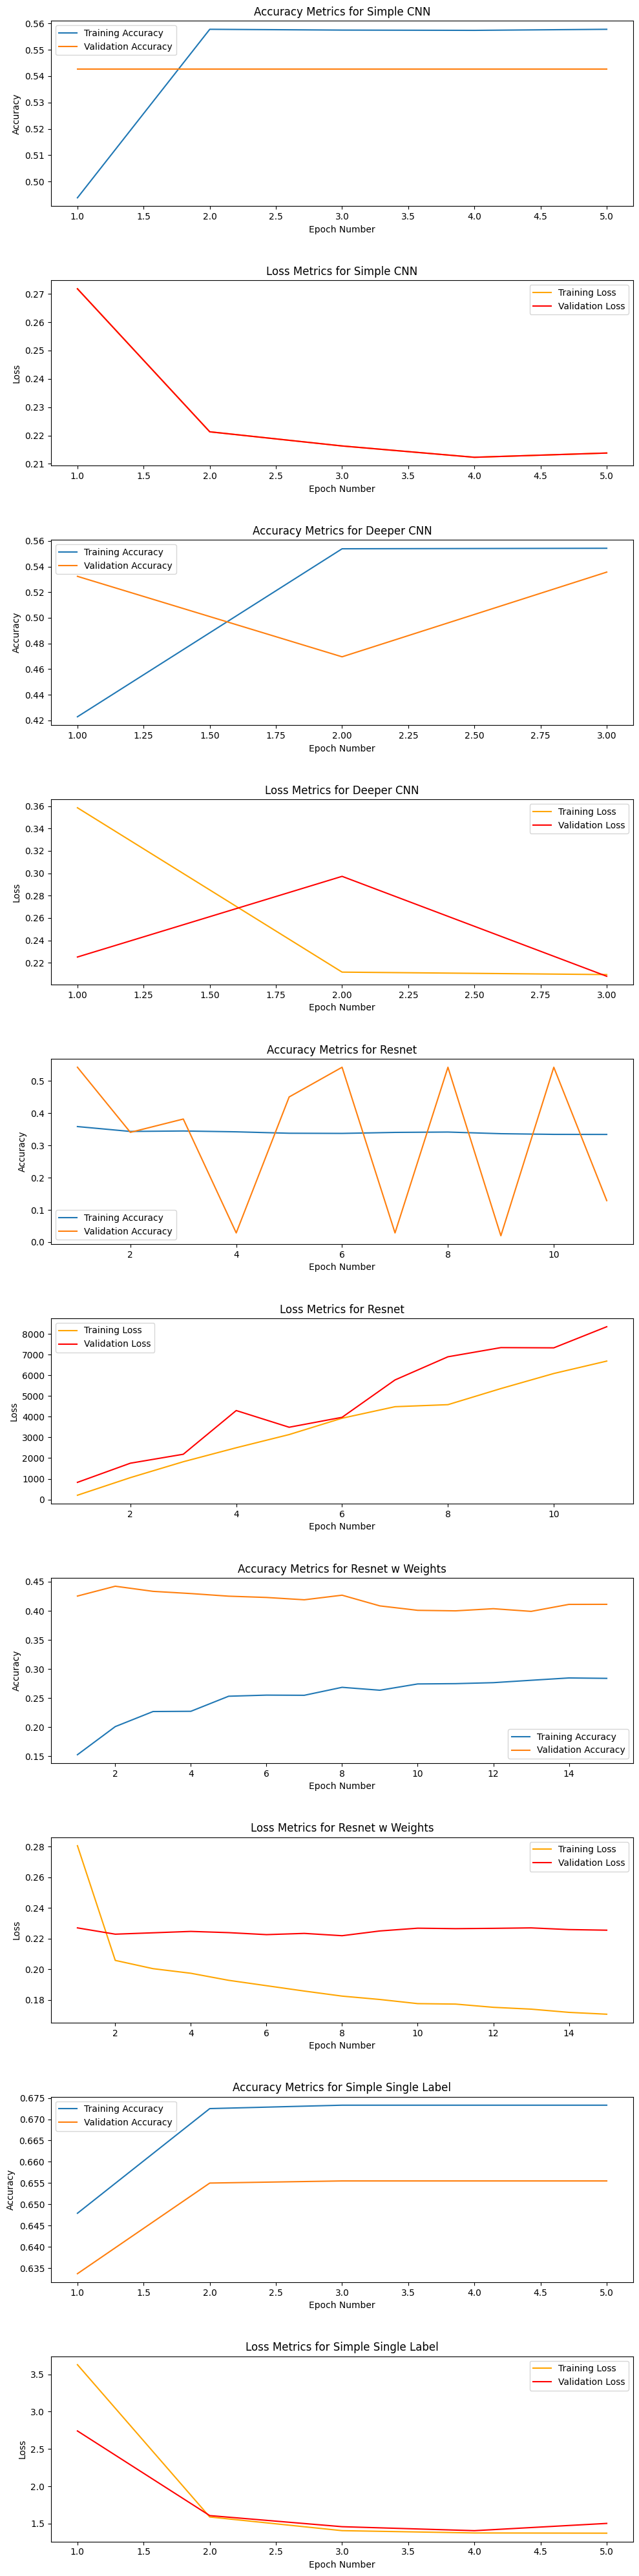

In [26]:
models = results_df['Model'].unique()

fig, axes = plt.subplots(nrows=len(models) * 2, ncols=1, figsize=(10, 40))
fig.tight_layout(pad=5.0)

# Plot each model's accuracy and loss in separate graphs
for i, model in enumerate(models):
    # Filter the dataframe for the current model
    model_df = results_df[results_df['Model'] == model]
    
    # Get the axis for accuracy and loss
    ax_acc = axes[i * 2]
    ax_loss = axes[i * 2 + 1]

    # Plot the accuracy metrics for the current model on the first axis
    ax_acc.plot(model_df['Epoch number'], model_df['Training accuracy'], label='Training Accuracy')
    ax_acc.plot(model_df['Epoch number'], model_df['Val_accuracy'], label='Validation Accuracy')
    ax_acc.set_title(f'Accuracy Metrics for {model}')
    ax_acc.set_xlabel('Epoch Number')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

    # Plot the loss metrics for the current model on the second axis
    ax_loss.plot(model_df['Epoch number'], model_df['Training loss'], label='Training Loss', color='orange')
    ax_loss.plot(model_df['Epoch number'], model_df['Val_loss'], label='Validation Loss', color='red')
    ax_loss.set_title(f'Loss Metrics for {model}')
    ax_loss.set_xlabel('Epoch Number')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

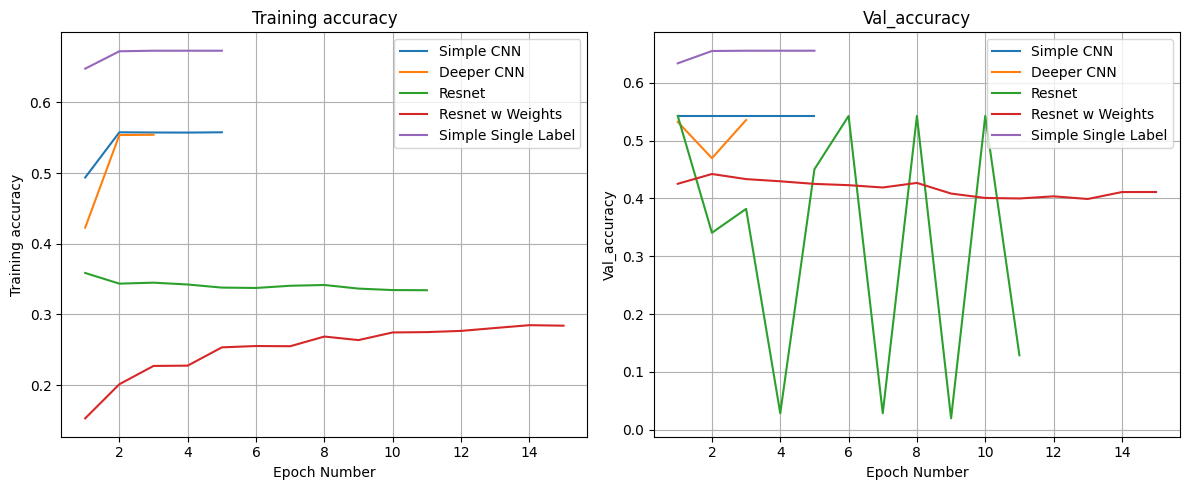

In [27]:
selected_metrics = ['Training accuracy', 'Val_accuracy']

# Create a figure and set of subplots for the selected metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  # Adjust subplot grid to 1 row, 2 columns

# Iterate over the selected metrics to create a subplot for each
for i, metric in enumerate(selected_metrics):
    for model in results_df['Model'].unique():
        # Filter data for each model and plot against the epoch number
        subset = results_df[results_df['Model'] == model]
        axes[i].plot(subset['Epoch number'], subset[metric], label=model)
    
    axes[i].set_title(metric)
    axes[i].set_xlabel('Epoch Number')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


## 2. Insights On Model Accuracy

1. Simple CNN
- Good baseline for us to work off of. It performed consistently on the training dataset and the validation set, achieveing around the same accuracy. The plateu indicates that that the model might be underfitting, meaning it is too simple to capture the complexity of the data.

2. Deeper CNN
- Despite being more complex than the simple CNN, with more features, it performed worse than the simple CNN, at least in the inital stages. We would have like to give it more time to train, but we are severely limited by computational resources.

3. Resnet
- Its training accuracy decreases over time, and its validation accuracy fluctuates widly. This might be due to the model learning representations that are not generalizing well to the unseen data, or it could be a sign of overfitting.
- The ResNet seems to be performing below the deeper CNN in terms of training accuracy, which is unexpected as ResNets are typically quite powerful. Could be because we are not employing the resnet model correctly

4. ResNet w/ Weights
- By far the worst performer across all our attempts. It improves over time in its training accuracy, but it plateaues at under 0.3, even below the training accuracy of the unmodified resnet model. It seems that our changes made this model perform worse. Potentially due to poor choice of hyper parameters.

5. Simple Single Label
- Our last attempt, and the most succesful, albeit having a simpler problem to solve. Again, it shows the same tendencies as the simple CNN model, plateuing after epoch 2. 


### 3. General Insights Across Models
- The training accuracy is consistently higher than the validation accuracy for all models except for the "Simple Single Label". This is typical, as models will generally perform better on data they have seen (training data) than on new, unseen data (validation data).
- No model shows a clear trend of convergence towards high accuracy on the validation set, implying that we have not uncovered the true reason for the models' mediocre perforamnce. Perhaps with greater time, resources, and experimentation, we can get to the bottom of the issues that plauge our models.




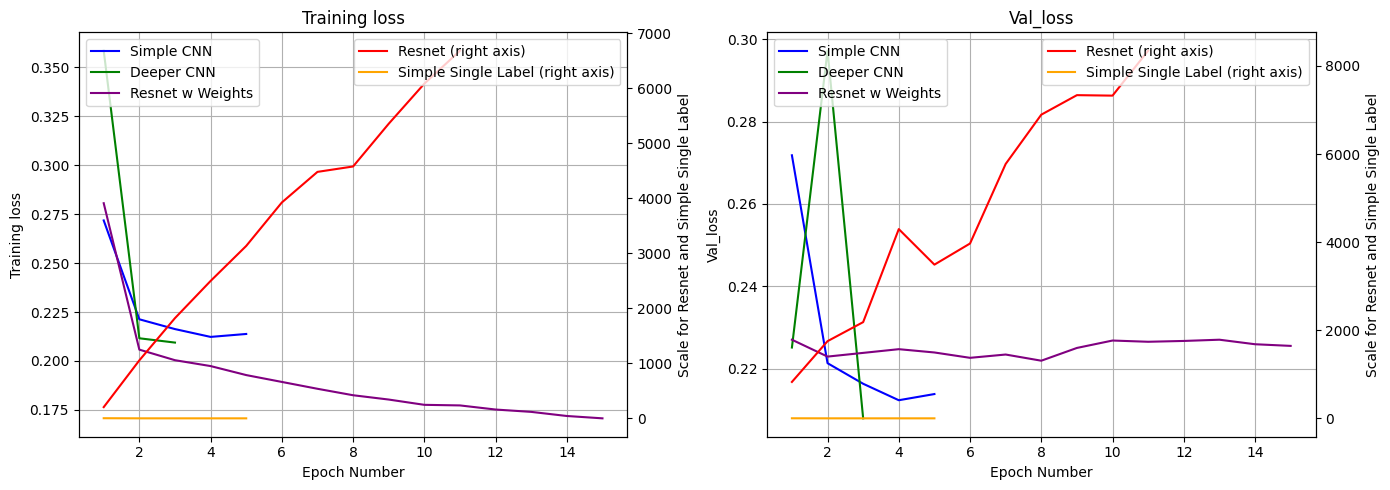

In [28]:
# Specify the metrics for dual axis due to scale differences
dual_axis_metrics = ['Training loss', 'Val_loss']

# Define colors for each model for clarity
colors = {
    'Simple CNN': 'blue',
    'Deeper CNN': 'green',
    'Resnet': 'red',
    'Resnet w Weights': 'purple',
    'Simple Single Label': 'orange'
}

# Create a figure and set of subplots for these specific metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate over the specified metrics to create a subplot for each
for i, metric in enumerate(dual_axis_metrics):
    ax1 = axes[i]  # Primary axis
    ax2 = ax1.twinx()  # Secondary axis for the large-scale data models
    
    # Plot each model on the appropriate axis with specific colors
    for model in results_df['Model'].unique():
        subset = results_df[results_df['Model'] == model]
        if model in ['Resnet', 'Simple Single Label']:
            ax2.plot(subset['Epoch number'], subset[metric], label=model + ' (right axis)', color=colors[model])
        else:
            ax1.plot(subset['Epoch number'], subset[metric], label=model, color=colors[model])

    ax1.set_title(metric)
    ax1.set_xlabel('Epoch Number')
    ax1.set_ylabel(metric)
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Configure the secondary axis
    ax2.set_ylabel('Scale for Resnet and Simple Single Label')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


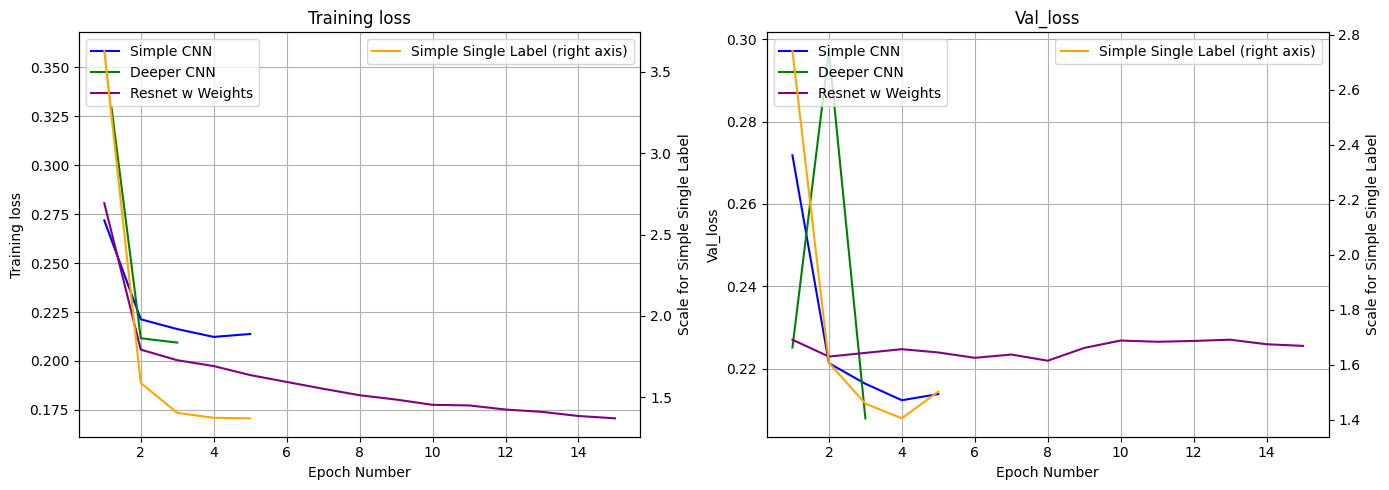

In [29]:
# Specify the metrics for dual axis due to scale differences
dual_axis_metrics = ['Training loss', 'Val_loss']

# Define colors for each model for clarity
colors = {
    'Simple CNN': 'blue',
    'Deeper CNN': 'green',
    'Resnet w Weights': 'purple',
    'Simple Single Label': 'orange'
}

# Create a figure and set of subplots for these specific metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Iterate over the specified metrics to create a subplot for each
for i, metric in enumerate(dual_axis_metrics):
    ax1 = axes[i]  # Primary axis
    ax2 = ax1.twinx()  # Secondary axis for 'Simple Single Label'
    
    # Plot each model on the appropriate axis with specific colors
    for model in results_df['Model'].unique():
        if model != 'Resnet':  # Exclude 'Resnet' from plotting
            subset = results_df[results_df['Model'] == model]
            if model == 'Simple Single Label':
                ax2.plot(subset['Epoch number'], subset[metric], label=model + ' (right axis)', color=colors[model])
            else:
                ax1.plot(subset['Epoch number'], subset[metric], label=model, color=colors[model])

    ax1.set_title(metric)
    ax1.set_xlabel('Epoch Number')
    ax1.set_ylabel(metric)
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Configure the secondary axis
    ax2.set_ylabel('Scale for Simple Single Label')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## 3. Insights On Model Loss


All models are learning (decreasing training loss yay!)

the vast majority of them drop significantly from the 1st to 2nd epoch, then taper off and plateu after that

This translates to the validation loss as well (except for the resnet with weights and the deeper CNN)

The simple CNN models seem to perform better at minimising validation loss, which is more important as it shows how well the model is able to generalize from training data to new data.

Most importantly, all our models seem to reach the capacity for learning very quickly, around 2 to 3 epochs
- A rapid decrease in loss or rapid convergence might indicate that the learning rate is set quite high. While this can lead to quicker convergence, it can also mean that the model is not fine-tuning its parameters to the nuanced patterns in the data.
- Contradictorily, this points to the fact that our models are not complex enough, which also goes against our results of the simple CNN being the most effective CNN


## 3. Insights On Classification Accuracy Across Categories


In [30]:
metadata_path = 'C:\\Users\\admin\\Desktop\\archive\\Class_Accuracy.csv'
Class_Accuracy = pd.read_csv(metadata_path)
Class_Accuracy

,Model,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Finding,Hernia,Test Accuracy,Test Loss
0,Deeper CNN Model,52.70%,49.50%,50.00%,52.30%,50.60%,50.90%,49.30%,48.80%,49.10%,49.60%,48.00%,49.60%,48.40%,50.00%,47.50%,NaN,NaN
1,Resnet1,49.85%,50.87%,49.94%,49.53%,50.90%,48.91%,49.72%,49.33%,49.73%,51.01%,49.39%,49.83%,49.72%,49.79%,50.27%,53.46%,783.430000
2,Resnet2,49.85%,50.87%,49.94%,49.53%,50.90%,48.91%,49.72%,49.33%,49.73%,51.01%,49.39%,49.83%,49.72%,49.79%,50.27%,57.66%,0.227939
3,Simple Model with Single label,66.23%,67.17%,64.87%,66.45%,67.51%,65.92%,66.73%,65.38%,67.12%,64.99%,65.77%,66.60%,67.33%,65.94%,67.02%,64.92%,0.111356
4,Average,54.66%,54.60%,53.69%,54.45%,54.98%,53.66%,53.87%,53.21%,53.92%,54.15%,53.14%,53.96%,53.79%,53.88%,53.77%,NaN,NaN


The similar performance across different categories and models also hints at the inherent difficulty of the diagnostic task. Chest X-rays can be complex to analyze due to the subtle nature of some conditions and the high variability between different cases. Models might be capturing some disease signals but not enough to clearly distinguish between all categories effectively.

________________________________________________________________________________________________________________________
# Recommendations



### 1. Using Bounding Boxes

In a separate .csv file, bounding boxes for the conditions were provided, specifying where in an CXR a disease is located

In [32]:
metadata_path2 = 'C:\\Users\\admin\\Desktop\\archive\\BBox_List_2017.csv'
bb_df = pd.read_csv(metadata_path2)

bb_df

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


![alternatvie text](https://github.com/quammenn/Test/assets/145742237/3b46367f-7eb2-42fa-8469-3b0c0cd68faf)


Our dataset included information for the bounding boxes across all of the CXRs, the accuracy would have likely been greatly improved. Implementing bounding boxes will have several key benefits
1. In traning, the CNN can focus on specific regions within the CXR rather than analyzing the entire image. This allows the CNN concentrate on relevant features for classification, improving the association of detected objects with corresponding class labels
2. Reduces occlusion. Some of the CXRs given include foreign objects, such as pacemakers, or medical equipment. Bounding boxes can help the CNN better discern and classify objects even when they are partially occluded
3. The issue of classifying CXRs is extremely granular. Features are miniscule, and what differentiates one disease from another is minute. An extreme level of detail is required. Bounding boxes enable the CNN to perform fine-grained classification by zooming in on specific regions of interest

## 3. The Importance Of A Building Block Approach

Multi-label classification using a CNN presents an immense challenge for us as students, particularly due to the complexity of learning and distinguishing between multiple overlapping and non-exclusive labels. This classification often requires a model to capture intricate interdependencies and correlations among labels, demanding large datasets and significant computational resources for effective training. For us students with extremely limited computational and time resources, adopting a building block approach can be more beneficial. Starting with binary classification using a CNN simplifies the task to distinguishing just two classes (e.g., disease vs. no disease), which reduces both the learning complexity and computational demands. This step-by-step approach could have allowed us to first establish a strong foundation by mastering binary classification, gaining critical insights into model behavior and performance. These initial successes and understandings can then serve as a solid base, enabling a gradual and more manageable expansion into the more complex domain of multi-label classification. This progressive learning strategy not only optimizes resource use but also enhances the overall development and tuning of the models.
